# Práctica NLP: Análisis de Reseñas de Amazon

### Autor: Juan David Pardo Pinzón

# 1. Descarga y Análisis Exploratorio del Corpus de Videojuegos.

## Instalación de librerías necesarias para el proceso de análisis

In [1]:
!pip install wordcloud
!pip install num2words
!pip install stop_words
!pip install gensim
!pip install nltk
!pip install wget
!pip install numpy
!pip install scikit-learn
!pip install threadpoolctl
!pip install --upgrade threadpoolctl

## Librerías, Configuración Librerias Requeridos EDA

In [2]:
import os
os.getcwd()

import shutil
import gzip
import json
import pandas as pd
from urllib.request import urlopen


import pandas as pd
import numpy as np

from nltk import ngrams
from collections import Counter
from nltk.probability import FreqDist


from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
from sklearn.manifold import TSNE



import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from wordcloud import WordCloud


import unicodedata
from num2words import num2words
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pardo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Descgarga del Dataset

Se ha decidido trabajar con el dataset de revisiones de ventas de videojuegos de Amazon, que contiene un total de 2,565,349 revisiones sobre una base de 84,894 productos para el análisis. Puedes acceder directamente al dataset [aquí](https://cseweb.ucsd.edu//~jmcauley/datasets/amazon_v2/index.html).

In [5]:
!curl -O https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Video_Games.json.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  498M    0 98304    0     0   118k      0  1:11:46 --:--:--  1:11:46  118k
  0  498M    0 1488k    0     0   880k      0  0:09:39  0:00:01  0:09:38  881k
  0  498M    0 3712k    0     0  1373k      0  0:06:11  0:00:02  0:06:09 1374k
  1  498M    1 6736k    0     0  1825k      0  0:04:39  0:00:03  0:04:36 1826k
  2  498M    2 10.2M    0     0  2232k      0  0:03:48  0:00:04  0:03:44 2233k
  2  498M    2 13.6M    0     0  2452k      0  0:03:28  0:00:05  0:03:23 2839k
  3  498M    3 16.0M    0     0  2451k      0  0:03:28  0:00:06  0:03:22 2982k
  3  498M    3 18.0M    0     0  2395k      0  0:03:33  0:00:07  0:03:26 2947k
  3  498M    3 19.7M    0     0  2329k      0  0:03:39  0:00:08  0:03:31 2701k
  4  498M    4 21.0M    0     0  2203k      0  0:03

El código determina la ubicación del archivo "Video_Games.json.gz", lo descomprime y guarda el archivo JSON resultante en la carpeta "data" para su posterior análisis.

In [3]:
# Nombre del archivo comprimido
compressed_file = "Video_Games.json.gz"
# Ruta del archivo comprimido
compressed_file_path = "C:\\Users\\pardo\\Documents\\BigData_AI_MachineLearning_FullStackBootcamp_2023\\14. NLP\\Practica NLP Juan David Pardo Pinzon\\" + compressed_file  # Reemplaza con la ruta correcta

# Carpeta donde se guardará el archivo JSON
output_folder = "data"

# Verificar si la carpeta de salida existe, si no, crearla
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Ruta de salida para el archivo JSON
output_json_path = os.path.join(output_folder, "Video_Games.json")

# Extraer el archivo JSON del archivo comprimido
with open(output_json_path, 'wb') as f_out, gzip.open(compressed_file_path, 'rb') as f_in:
    shutil.copyfileobj(f_in, f_out)

Se realiza una lectura preliminar de un par de registros para verificar la descarga adecuada de los datos.

In [4]:
with open('data/Video_Games.json', 'r') as file:
    for _ in range(2):  # Lee las primeras 5 líneas
        print(file.readline())

{"overall": 1.0, "verified": true, "reviewTime": "06 9, 2014", "reviewerID": "A21ROB4YDOZA5P", "asin": "0439381673", "reviewerName": "Mary M. Clark", "reviewText": "I used to play this game years ago and loved it. I found this did not work on my computer even though it said it would work with Windows 7.", "summary": "Did not like this", "unixReviewTime": 1402272000}

{"overall": 3.0, "verified": true, "reviewTime": "05 10, 2014", "reviewerID": "A3TNZ2Q5E7HTHD", "asin": "0439381673", "reviewerName": "Sarabatya", "reviewText": "The game itself worked great but the story line videos would never play, the sound was fine but the picture would freeze and go black every time.", "summary": "Almost Perfect", "unixReviewTime": 1399680000}



Se ha creado una función para contar el número de registros presentes en el archivo JSON, y se verifica si coincide con la información inicial proporcionada por la fuente de descarga del conjunto de datos.

In [5]:
def contar_registros(archivo):
    with open(archivo, 'r') as file:
        num_registros = sum(1 for line in file)
    return num_registros

# Ruta del archivo JSON
archivo_json = "data/Video_Games.json"

# Contar registros
num_registros = contar_registros(archivo_json)
print("Número de registros en el archivo JSON:", num_registros)


Número de registros en el archivo JSON: 2565349


Este script lee el archivo JSON línea por línea y lo almacena en un array del mismo nombre, que será utilizado posteriormente para el análisis. Además, se realiza una comprobación llamando a la longitud total del array, lo que nos permite verificar que se esté cargando la base de datos completa. También se imprime el primer registro completo del array para tener una vista preliminar de los datos.

In [8]:
import json

# Lista para almacenar los datos
data = []

# Ruta del archivo JSON
archivo_json = 'data/Video_Games.json'

# Carga de los metadatos desde el archivo JSON
with open(archivo_json, 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))
# Longitud total de la lista, este número es igual al número total de productos
print("Número total de reviews:", len(data))
# Primer registro de la lista
print("Primer registro del archivo JSON:")
print(data[0])

Número total de reviews: 2565349
Primer registro del archivo JSON:
{'overall': 1.0, 'verified': True, 'reviewTime': '06 9, 2014', 'reviewerID': 'A21ROB4YDOZA5P', 'asin': '0439381673', 'reviewerName': 'Mary M. Clark', 'reviewText': 'I used to play this game years ago and loved it. I found this did not work on my computer even though it said it would work with Windows 7.', 'summary': 'Did not like this', 'unixReviewTime': 1402272000}


Procedemos a convertir el conjunto de datos almacenado en el array 'data' en un DataFrame utilizando la biblioteca Pandas.

In [9]:
# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)
df.shape

(2565349, 12)

Verificamos el tipo de dato de cada variable en el DataFrame para asegurarnos de su correcta interpretación.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565349 entries, 0 to 2565348
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   verified        bool   
 2   reviewTime      object 
 3   reviewerID      object 
 4   asin            object 
 5   reviewerName    object 
 6   reviewText      object 
 7   summary         object 
 8   unixReviewTime  int64  
 9   vote            object 
 10  style           object 
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 217.7+ MB


Realizamos una visualización de los datos para obtener una perspectiva general de su distribución y características.

In [11]:
df.head(5).T

,0,1,2,3,4
overall,1.0,3.0,4.0,1.0,4.0
verified,True,True,True,True,True
reviewTime,"06 9, 2014","05 10, 2014","02 7, 2014","02 7, 2014","01 16, 2014"
reviewerID,A21ROB4YDOZA5P,A3TNZ2Q5E7HTHD,A1OKRM3QFEATQO,A2XO1JFCNEYV3T,A19WLPIRHD15TH
asin,0439381673,0439381673,0439381673,0439381673,0439381673
reviewerName,Mary M. Clark,Sarabatya,Amazon Customer,ColoradoPartyof5,Karen Robinson
reviewText,I used to play this game years ago and loved i...,The game itself worked great but the story lin...,I had to learn the hard way after ordering thi...,The product description should state this clea...,I would recommend this learning game for anyon...
summary,Did not like this,Almost Perfect,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,does not work on Mac OSX,Roughing it
unixReviewTime,1402272000,1399680000,1391731200,1391731200,1389830400
vote,NaN,NaN,15,11,NaN


Decidí restringir el análisis de las revisiones únicamente a aquellas que estén verificadas. Esta medida se tomó para asegurar que las valoraciones no estén sesgadas y para limitarnos a las opiniones de personas que realmente hayan adquirido el artículo.

In [12]:
# Filtrar los registros con la variable "verified" igual a True
df_verified = df[df['verified'] == True].copy()
df_verified.shape

(1948309, 12)

Para simplificar el análisis y reducir el ruido en los datos, he decidido conservar únicamente las variables "reviewText" y "overall", manteniendo el filtro de "verified - True". Esto nos permitirá centrarnos en las opiniones verificadas y en el contenido de las reseñas, descartando otras variables que podrían generar interferencias en nuestro análisis.

In [13]:
# Eliminación de variables innecesarias
var_to_drop = ['verified','reviewTime','reviewerID','asin','reviewerName','summary','unixReviewTime','vote','style','image']
df_verified.drop(columns = var_to_drop, inplace=True)
df_verified.head(5)

,overall,reviewText
0,1.0,I used to play this game years ago and loved i...
1,3.0,The game itself worked great but the story lin...
2,4.0,I had to learn the hard way after ordering thi...
3,1.0,The product description should state this clea...
4,4.0,I would recommend this learning game for anyon...


A continuación, procedemos a validar si existen revisiones vacías o nulas. Estas deberán ser eliminadas, ya que no aportan información útil al análisis de sentimientos.

In [14]:
df_verified.isnull().any()

overall       False
reviewText     True
dtype: bool

In [15]:
df_verified.isna().sum()

overall          0
reviewText    1595
dtype: int64

In [16]:
# Eliminar filas con valores nulos o NaN en df_verified
df_verified.dropna(inplace=True)

Se validó la eliminación efectiva de los registros vacíos o nulos.

In [17]:
df_verified.isnull().any()

overall       False
reviewText    False
dtype: bool

In [18]:
df_verified.isna().sum()

overall       0
reviewText    0
dtype: int64

## Cardinalidad de Vocabulario

A continuación se presenta la distribución de los datos por categoría:

In [19]:
# Contar el número de elementos en cada categoría de 'overall'
conteo_por_categoria = df_verified['overall'].value_counts()

# Calcular el valor porcentual
porcentaje_por_categoria = (conteo_por_categoria / len(df_verified)) * 100

# Mostrar los resultados
print("Número de elementos por categoría de 'overall':")
print(conteo_por_categoria)
print("\nValor porcentual por categoría de 'overall':")
print(porcentaje_por_categoria)

Número de elementos por categoría de 'overall':
overall
5.0    1191399
4.0     292700
1.0     216953
3.0     150671
2.0      94991
Name: count, dtype: int64

Valor porcentual por categoría de 'overall':
overall
5.0    61.200515
4.0    15.035593
1.0    11.144575
3.0     7.739760
2.0     4.879556
Name: count, dtype: float64


Se ha decidido tomar una muestra equivalente al 10% del conjunto de datos completo para su procesamiento.

In [97]:
# Obtener la muestra del DataFrame original
df_partition = df_verified.sample(frac=0.1, random_state=50)

# Guardar la muestra en un archivo CSV
df_partition.to_csv('df_partitions.csv', index=False)

print("El archivo 'df_partitions.csv' ha sido creado satisfactoriamente con la muestra df_partition.")

El archivo 'df_partitions.csv' ha sido creado satisfactoriamente con la muestra df_partition.


He creado una copia de los datos y los he almacenado en el archivo "df_partitions.csv". La siguiente parte del código llama al archivo y valida que estemos efectivamente obteniendo la información adecuada.

In [98]:
# Especifica la ruta del archivo df_partitions.csv
file_path = "df_partitions.csv"

# Carga el archivo CSV en un DataFrame de Pandas
df_partitions = pd.read_csv(file_path)

# Muestra las primeras filas del DataFrame para verificar la carga
print(df_partitions.head())

   overall                                         reviewText
0      4.0  It's doing it's job and giving the tablet a lo...
1      5.0  Very sturdy and great for the price! I purchas...
2      5.0                                       Works great!
3      5.0                            Another awesome Amiibo!
4      5.0   Exactly as advertised, and just the right price!


A continuación procedemos a convierte el texto de las revisiones a minúsculas, lo divide en palabras, cuenta la frecuencia de cada palabra y la almacena en un diccionario.

In [99]:
splitted_reviews = df_partition['reviewText'].str.lower().str.split()
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)
vocabulary_ = Counter(words)

In [100]:
print(f"Las review del dataset está compuesto de {len(vocabulary_)} palabras.")

Las review del dataset está compuesto de 195261 palabras.


## Distribución de reviews según la calificación en estrellas

Distribución de las reviews según el ranking de Amazon, que va de 1 a 5.

In [101]:
df_partition['overall'].value_counts().sort_values(ascending=True)

overall
2.0      9627
3.0     14871
1.0     21642
4.0     29142
5.0    119389
Name: count, dtype: int64

Se muestra gráficamente la distribución de las reviews en forma de porcentaje.

Distribución de Reviews según el Ranking de Amazon:
Ranking 1.0: 21642 reviews - 11.12%
Ranking 2.0: 9627 reviews - 4.95%
Ranking 3.0: 14871 reviews - 7.64%
Ranking 4.0: 29142 reviews - 14.97%
Ranking 5.0: 119389 reviews - 61.33%


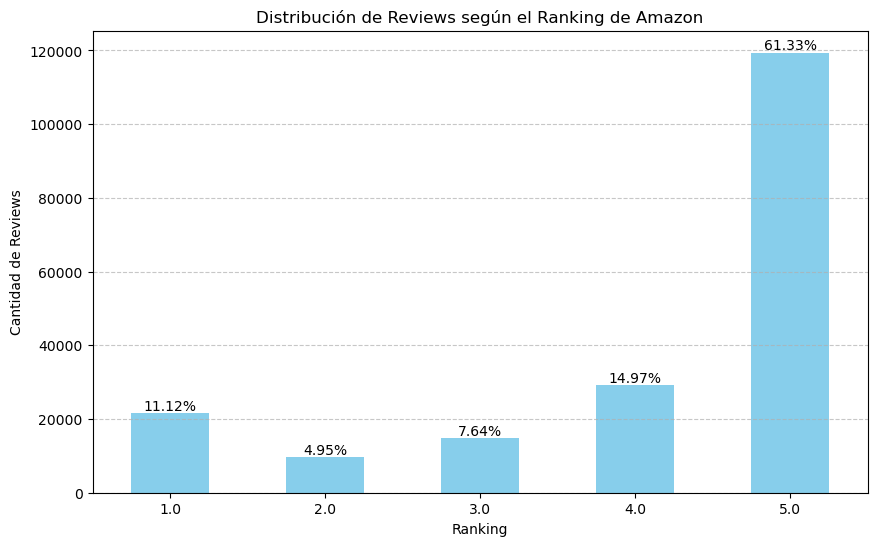

In [102]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener los recuentos de cada valor de 'overall' y ordenar de menor a mayor
counts = df_partition['overall'].value_counts().sort_index()

# Calcular los porcentajes
total_reviews = counts.sum()
porcentajes = [(count / total_reviews) * 100 for count in counts]

# Crear el histograma con los porcentajes en las etiquetas
plt.figure(figsize=(10, 6))
bars = counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Reviews según el Ranking de Amazon')
plt.xlabel('Ranking')
plt.ylabel('Cantidad de Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Agregar los porcentajes a las etiquetas de las barras
for i, patch in enumerate(bars.patches):
    plt.text(patch.get_x() + patch.get_width() / 2, patch.get_height() + 0.05, f'{porcentajes[i]:.2f}%', ha='center', va='bottom')

# Mostrar los datos escritos
print("Distribución de Reviews según el Ranking de Amazon:")
for ranking, count, percentage in zip(counts.index, counts, porcentajes):
    print(f'Ranking {ranking}: {count} reviews - {percentage:.2f}%')

plt.show()



## Recuento de reviews positivas y negativas

In [103]:
# Reagrupar las categorías de la variable 'overall'
df_partition['sentiment'] = df_partition['overall'].apply(lambda x: 'Negativo' if x <= 3 else 'Positivo')
# Conteo de los valores de la nueva columna 'sentiment'
count_sentiment = df_partition['sentiment'].value_counts()
print(count_sentiment)

sentiment
Positivo    148531
Negativo     46140
Name: count, dtype: int64


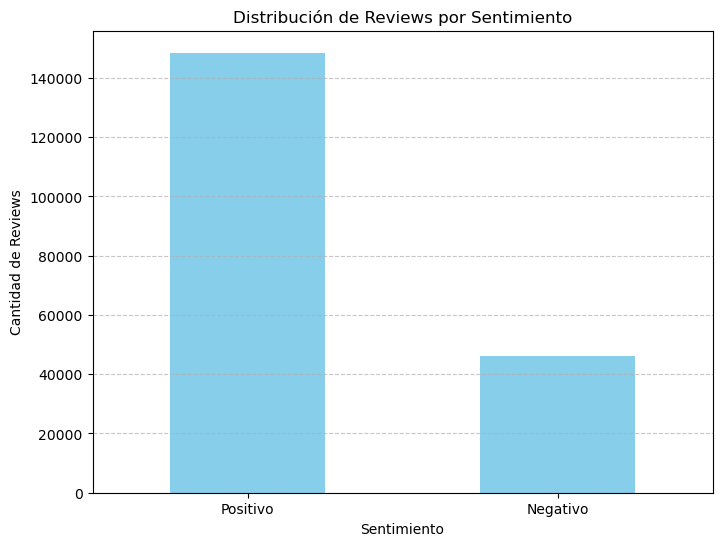

In [104]:
# Crear el histograma
plt.figure(figsize=(8, 6))
count_sentiment.plot(kind='bar', color='skyblue')
plt.title('Distribución de Reviews por Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## N-gramas más frecuentes

In [105]:
most_common = vocabulary_.most_common(10)
most_common

[('the', 467229),
 ('and', 249440),
 ('i', 239869),
 ('to', 230685),
 ('a', 222381),
 ('it', 185788),
 ('is', 150259),
 ('of', 137915),
 ('this', 137493),
 ('for', 118493)]

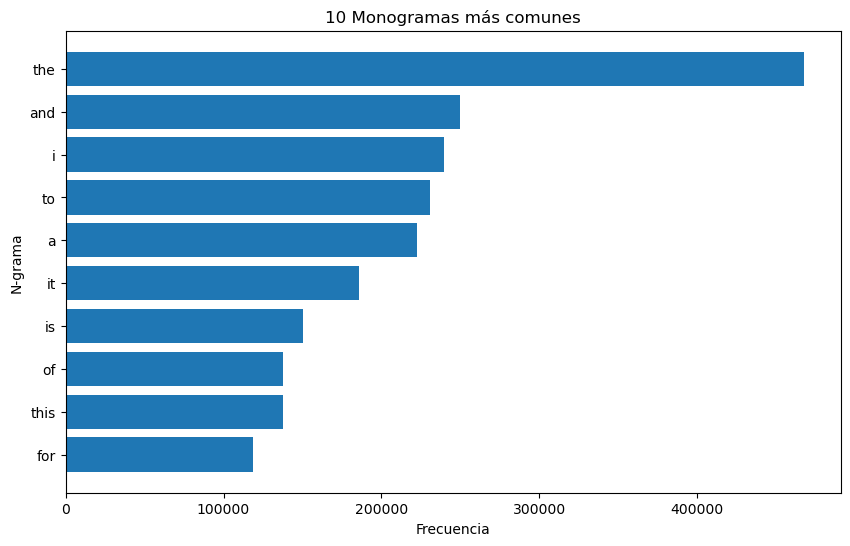

In [106]:
words_1_gram = [w[0] for w in most_common]  # result es el resultado obtenido de la función most_common_ngrams
freqs_1_gram = [w[1] for w in most_common]
freqs_1_gram, words_1_gram = zip(*sorted(zip(freqs_1_gram, words_1_gram)))

plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura según tus preferencias
plt.title("10 Monogramas más comunes")
plt.barh(words_1_gram[-10:], freqs_1_gram[-10:])  # Muestra solo las 10 palabras más comunes
plt.xlabel("Frecuencia")
plt.ylabel("N-grama")
plt.show()


Bigramas

In [107]:
# Definir la función para calcular los N-gramas más frecuentes
def most_common_ngrams(text, n, num):
    # Obtener los N-gramas del texto
    n_grams = ngrams(text.split(), n)
    
    # Contar la frecuencia de cada N-grama
    n_gram_freq = Counter(n_grams)
    
    # Devolver los 'num' N-gramas más frecuentes
    return n_gram_freq.most_common(num)

# Ejemplo de uso
text = " ".join(df_partition['reviewText'])  # Concatenar todos los textos en una cadena
n = 2  # Número de palabras por N-grama
num = 10  # Número de N-gramas más frecuentes a mostrar

# Obtener los N-gramas más frecuentes
result = most_common_ngrams(text, n, num)

# Mostrar los resultados
print(f"Los {num} N-gramas más frecuentes son:")
for n_gram, freq in result:
    print(f"{n_gram}: {freq} veces")

Los 10 N-gramas más frecuentes son:
('of', 'the'): 37582 veces
('in', 'the'): 21295 veces
('the', 'game'): 21052 veces
('is', 'a'): 20465 veces
('on', 'the'): 19857 veces
('this', 'game'): 19545 veces
('and', 'the'): 18527 veces
('for', 'the'): 17907 veces
('I', 'have'): 17001 veces
('to', 'the'): 15786 veces


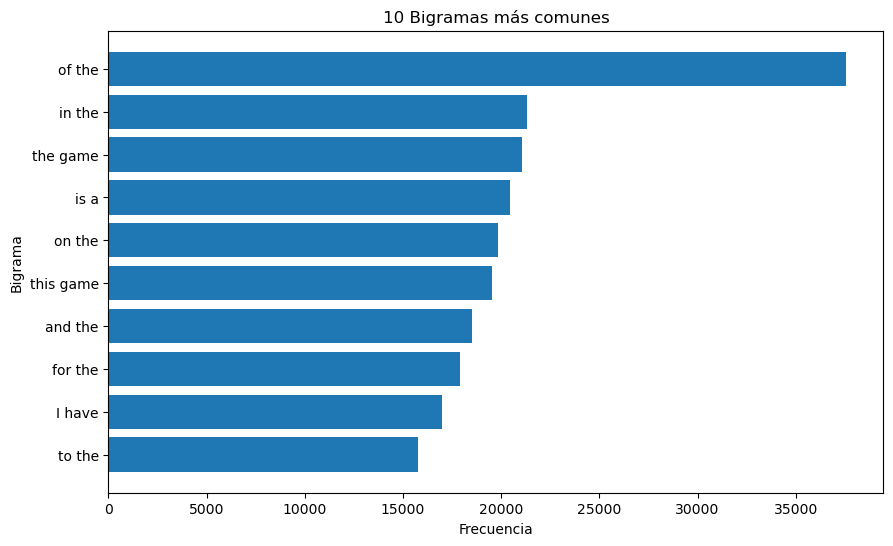

In [108]:
# Definir la función para calcular los bigramas más frecuentes
def most_common_bigrams(text, num):
    # Obtener los bigramas del texto
    bigrams = ngrams(text.split(), 2)
    
    # Contar la frecuencia de cada bigrama
    bigram_freq = Counter(bigrams)
    
    # Devolver los 'num' bigramas más frecuentes
    return bigram_freq.most_common(num)

# Ejemplo de uso
text = " ".join(df_partition['reviewText'])  # Concatenar todos los textos en una cadena
num = 10  # Número de bigramas más frecuentes a mostrar

# Obtener los bigramas más frecuentes
result = most_common_bigrams(text, num)

# Separar los resultados en palabras y frecuencias
words_bigram = [" ".join(map(str, w[0])) for w in result]
freqs_bigram = [w[1] for w in result]

# Ordenar los bigramas por frecuencia
freqs_bigram, words_bigram = zip(*sorted(zip(freqs_bigram, words_bigram)))

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(words_bigram, freqs_bigram)
plt.title("10 Bigramas más comunes")
plt.xlabel("Frecuencia")
plt.ylabel("Bigrama")
plt.show()

Trigramas

In [109]:
# Definir la función para calcular los N-gramas más frecuentes
def most_common_ngrams(text, n, num):
    # Obtener los N-gramas del texto
    n_grams = ngrams(text.split(), n)
    
    # Contar la frecuencia de cada N-grama
    n_gram_freq = Counter(n_grams)
    
    # Devolver los 'num' N-gramas más frecuentes
    return n_gram_freq.most_common(num)

# Ejemplo de uso
text = " ".join(df_partition['reviewText'])  # Concatenar todos los textos en una cadena
n = 3  # Número de palabras por N-grama
num = 10  # Número de N-gramas más frecuentes a mostrar

# Obtener los N-gramas más frecuentes
result = most_common_ngrams(text, n, num)

# Mostrar los resultados
print(f"Los {num} N-gramas más frecuentes son:")
for n_gram, freq in result:
    print(f"{n_gram}: {freq} veces")

Los 10 N-gramas más frecuentes son:
('a', 'lot', 'of'): 5355 veces
('I', 'bought', 'this'): 3698 veces
('one', 'of', 'the'): 3687 veces
('This', 'game', 'is'): 3361 veces
('this', 'game', 'is'): 3200 veces
('This', 'is', 'a'): 3112 veces
('you', 'have', 'to'): 2716 veces
('is', 'a', 'great'): 2691 veces
('this', 'is', 'a'): 2554 veces
('the', 'game', 'is'): 2459 veces


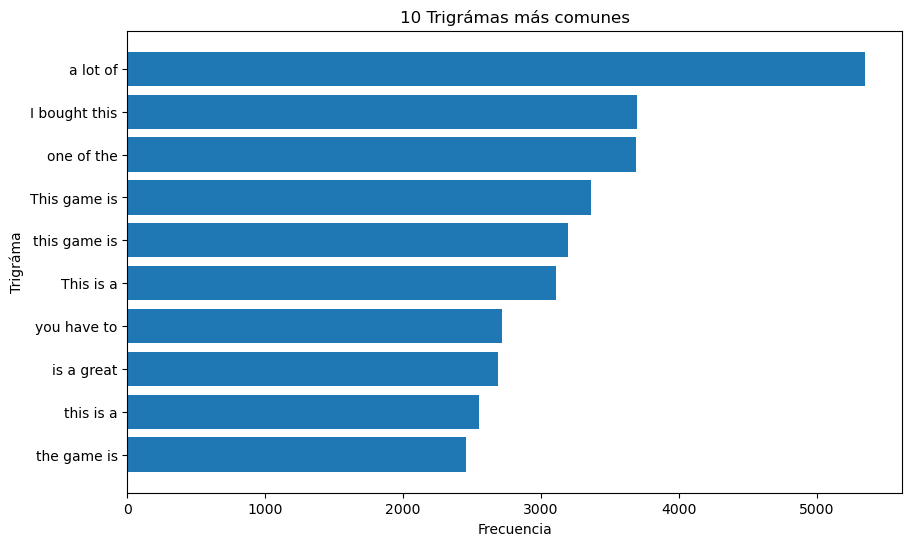

In [110]:
# Definir la función para calcular los trigrámas más frecuentes
def most_common_trigrams(text, num):
    # Obtener los trigrámas del texto
    trigrams = ngrams(text.split(), 3)
    
    # Contar la frecuencia de cada trigrama
    trigram_freq = Counter(trigrams)
    
    # Devolver los 'num' trigrámas más frecuentes
    return trigram_freq.most_common(num)

# Ejemplo de uso
text = " ".join(df_partition['reviewText'])  # Concatenar todos los textos en una cadena
num = 10  # Número de trigrámas más frecuentes a mostrar

# Obtener los trigrámas más frecuentes
result = most_common_trigrams(text, num)

# Separar los resultados en palabras y frecuencias
words_trigram = [" ".join(map(str, w[0])) for w in result]
freqs_trigram = [w[1] for w in result]

# Ordenar los trigrámas por frecuencia
freqs_trigram, words_trigram = zip(*sorted(zip(freqs_trigram, words_trigram)))

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(words_trigram, freqs_trigram)
plt.title("10 Trigrámas más comunes")
plt.xlabel("Frecuencia")
plt.ylabel("Trigráma")
plt.show()

Al validar la información obtenida a través de los n-gramas representados anteriormente, se destaca que la mayoría de las palabras representadas son stopwords. Esto dificulta la generación de un contexto claro para el significado de los n-gramas mediante la función de frecuencia. Por esta razón, decidí excluir las stopwords al calcular los n-gramas más frecuentes, ya que estas palabras suelen introducir ruido en el análisis al carecer de un significado contextual relevante. Al eliminarlas, espero poder enfocarnos en las palabras más relevantes dentro del conjunto de datos seleccionado.

# Los N-gramas más frecuentes, excluyendo las stopwords.

In [111]:
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

# Definir la función para calcular los N-gramas más frecuentes excluyendo stopwords
def most_common_ngrams(text, n, num):
    # Obtener las stopwords en el idioma inglés
    stop_words = set(stopwords.words('english'))
    
    # Obtener los N-gramas del texto excluyendo las stopwords
    words = [word for word in text.split() if word.lower() not in stop_words]
    n_grams = ngrams(words, n)
    
    # Contar la frecuencia de cada N-grama
    n_gram_freq = Counter(n_grams)
    
    # Devolver los 'num' N-gramas más frecuentes
    return n_gram_freq.most_common(num)

Monograma excluyendo stopwords

In [112]:
# Monogramas más Frecuentes
text = " ".join(df_partition['reviewText'])  # Concatenar todos los textos en una cadena
n = 1  # Número de palabras por N-grama
num = 10  # Número de N-gramas más frecuentes a mostrar

# Obtener los N-gramas más frecuentes excluyendo stopwords
result = most_common_ngrams(text, n, num)

# Mostrar los resultados
print(f"Los {num} N-gramas más frecuentes (excluyendo stopwords) son:")
for n_gram, freq in result:
    print(f"{n_gram}: {freq} veces")

Los 10 N-gramas más frecuentes (excluyendo stopwords) son:
('game',): 86870 veces
('like',): 37383 veces
('one',): 29450 veces
('great',): 28814 veces
('get',): 28129 veces
('good',): 26088 veces
('play',): 25859 veces
('would',): 23448 veces
('it.',): 22343 veces
('games',): 22214 veces


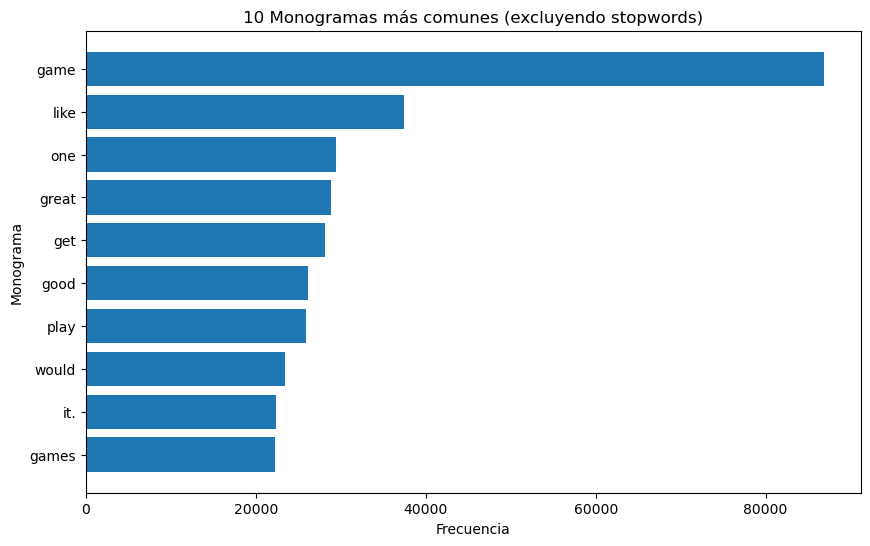

In [113]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

# Definir la función para calcular los N-gramas más frecuentes excluyendo stopwords
def most_common_ngrams(text, n, num):
    # Obtener los N-gramas del texto excluyendo stopwords
    tokens = [token for token in text.split() if token.lower() not in stopwords.words('english')]
    n_grams = ngrams(tokens, n)
    
    # Contar la frecuencia de cada N-grama
    n_gram_freq = Counter(n_grams)
    
    # Devolver los 'num' N-gramas más frecuentes
    return n_gram_freq.most_common(num)

# Monogramas más Frecuentes
text = " ".join(df_partition['reviewText'])  # Concatenar todos los textos en una cadena
n = 1  # Número de palabras por N-grama
num = 10  # Número de N-gramas más frecuentes a mostrar

# Obtener los N-gramas más frecuentes excluyendo stopwords
result = most_common_ngrams(text, n, num)

# Separar los resultados en palabras y frecuencias
words = [n_gram[0][0] for n_gram in result]
freqs = [n_gram[1] for n_gram in result]

# Ordenar los N-gramas por frecuencia
freqs, words = zip(*sorted(zip(freqs, words)))

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(words, freqs)
plt.title("10 Monogramas más comunes (excluyendo stopwords)")
plt.xlabel("Frecuencia")
plt.ylabel("Monograma")
plt.show()

Bigrama excluyendo stopwords

In [114]:
# Bigramas más Frecuentes
text = " ".join(df_partition['reviewText'])  # Concatenar todos los textos en una cadena
n = 2  # Número de palabras por N-grama
num = 10  # Número de N-gramas más frecuentes a mostrar

# Obtener los N-gramas más frecuentes excluyendo stopwords
result = most_common_ngrams(text, n, num)

# Mostrar los resultados
print(f"Los {num} N-gramas más frecuentes (excluyendo stopwords) son:")
for n_gram, freq in result:
    print(f"{n_gram}: {freq} veces")


Los 10 N-gramas más frecuentes (excluyendo stopwords) son:
('year', 'old'): 2542 veces
('would', 'recommend'): 2380 veces
('game', 'play'): 2165 veces
('great', 'game'): 1894 veces
('works', 'great'): 1745 veces
('feel', 'like'): 1700 veces
('Great', 'game'): 1595 veces
('son', 'loves'): 1595 veces
('play', 'game'): 1562 veces
('highly', 'recommend'): 1488 veces


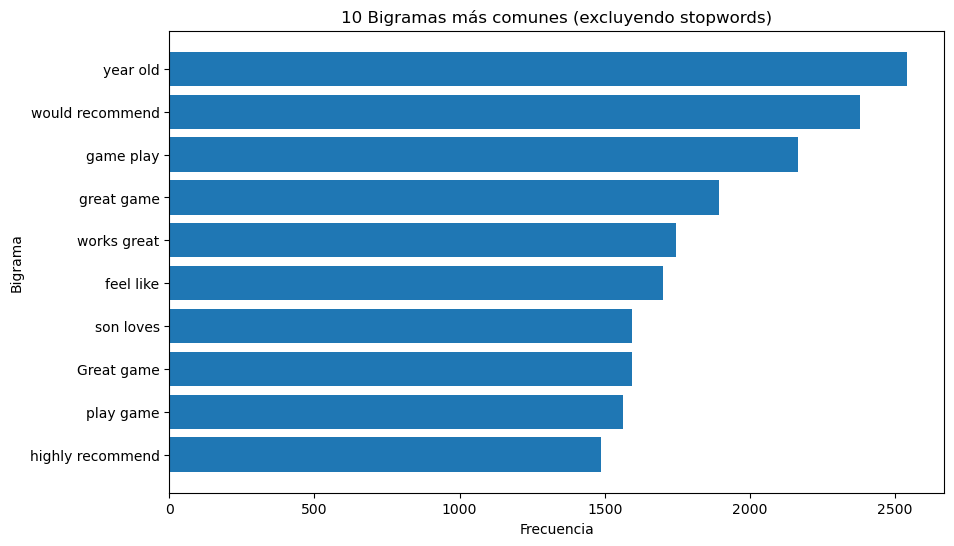

In [115]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

# Definir la función para calcular los bigramas más frecuentes excluyendo stopwords
def most_common_bigrams(text, num):
    # Obtener los bigramas del texto excluyendo stopwords
    tokens = [token for token in text.split() if token.lower() not in stopwords.words('english')]
    bigrams = ngrams(tokens, 2)
    
    # Contar la frecuencia de cada bigrama
    bigram_freq = Counter(bigrams)
    
    # Devolver los 'num' bigramas más frecuentes
    return bigram_freq.most_common(num)

# Bigramas más Frecuentes
text = " ".join(df_partition['reviewText'])  # Concatenar todos los textos en una cadena
num = 10  # Número de bigramas más frecuentes a mostrar

# Obtener los bigramas más frecuentes excluyendo stopwords
result = most_common_bigrams(text, num)

# Separar los resultados en palabras y frecuencias
words_bigram = [" ".join(map(str, w[0])) for w in result]
freqs_bigram = [w[1] for w in result]

# Ordenar los bigramas por frecuencia
freqs_bigram, words_bigram = zip(*sorted(zip(freqs_bigram, words_bigram)))

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(words_bigram, freqs_bigram)
plt.title("10 Bigramas más comunes (excluyendo stopwords)")
plt.xlabel("Frecuencia")
plt.ylabel("Bigrama")
plt.show()

Trigrama excluyendo stopwords

In [116]:
# Trigramas más Frecuentes
text = " ".join(df_partition['reviewText'])  # Concatenar todos los textos en una cadena
n = 3  # Número de palabras por N-grama
num = 10  # Número de N-gramas más frecuentes a mostrar

# Obtener los N-gramas más frecuentes excluyendo stopwords
result = most_common_ngrams(text, n, num)

# Mostrar los resultados
print(f"Los {num} trigrámas más frecuentes (excluyendo stopwords) son:")
for n_gram, freq in result:
    print(f"{n_gram}: {freq} veces")


Los 10 trigrámas más frecuentes (excluyendo stopwords) son:
('.', '.', '.'): 415 veces
('year', 'old', 'son'): 387 veces
('would', 'definitely', 'recommend'): 327 veces
('one', 'best', 'games'): 321 veces
('would', 'recommend', 'anyone'): 292 veces
('would', 'highly', 'recommend'): 273 veces
('would', 'recommend', 'game'): 259 veces
('son', 'loves', 'it.'): 250 veces
('5', 'year', 'old'): 243 veces
('6', 'year', 'old'): 222 veces


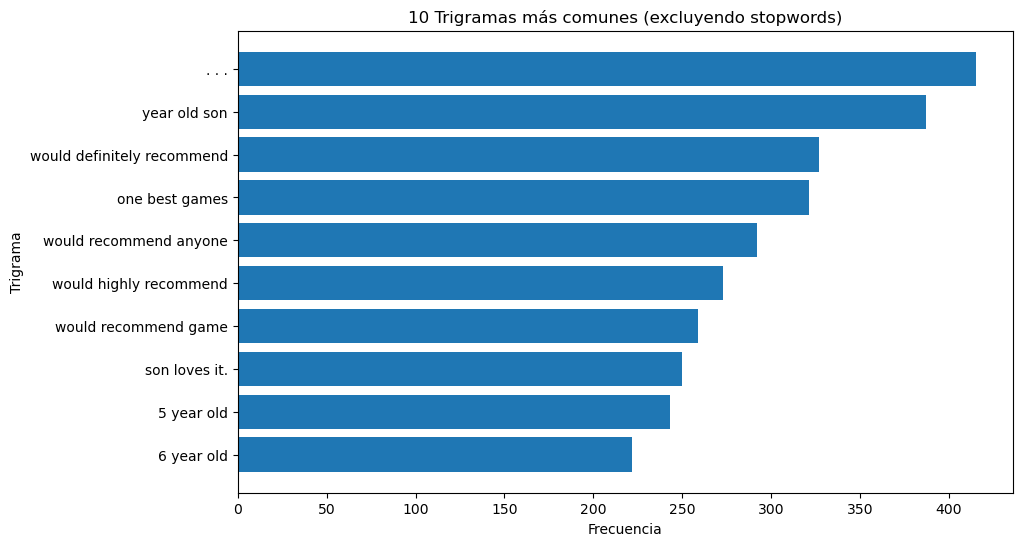

In [117]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

# Definir la función para calcular los trigramas más frecuentes excluyendo stopwords
def most_common_trigrams(text, num):
    # Obtener los trigramas del texto excluyendo stopwords
    tokens = [token for token in text.split() if token.lower() not in stopwords.words('english')]
    trigrams = ngrams(tokens, 3)
    
    # Contar la frecuencia de cada trigram
    trigram_freq = Counter(trigrams)
    
    # Devolver los 'num' trigramas más frecuentes
    return trigram_freq.most_common(num)

# Trigramas más Frecuentes
text = " ".join(df_partition['reviewText'])  # Concatenar todos los textos en una cadena
num = 10  # Número de trigramas más frecuentes a mostrar

# Obtener los trigramas más frecuentes excluyendo stopwords
result = most_common_trigrams(text, num)

# Separar los resultados en palabras y frecuencias
words_trigram = [" ".join(map(str, w[0])) for w in result]
freqs_trigram = [w[1] for w in result]

# Ordenar los trigramas por frecuencia
freqs_trigram, words_trigram = zip(*sorted(zip(freqs_trigram, words_trigram)))

# Crear el gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(words_trigram, freqs_trigram)
plt.title("10 Trigramas más comunes (excluyendo stopwords)")
plt.xlabel("Frecuencia")
plt.ylabel("Trigrama")
plt.show()


Como se puede apreciar en el conjunto de n-gramas representado anteriormente, existe un contexto más amplio sobre el mensaje que la revisión busca transmitir. En esta misma línea, considero que la aplicación de este método resulta muy útil para identificar el comportamiento del conjunto de datos y su sentido contextual.

## Nubes de Palabras

Nube de palabras generada a partir de todas las muestras de reseñas.

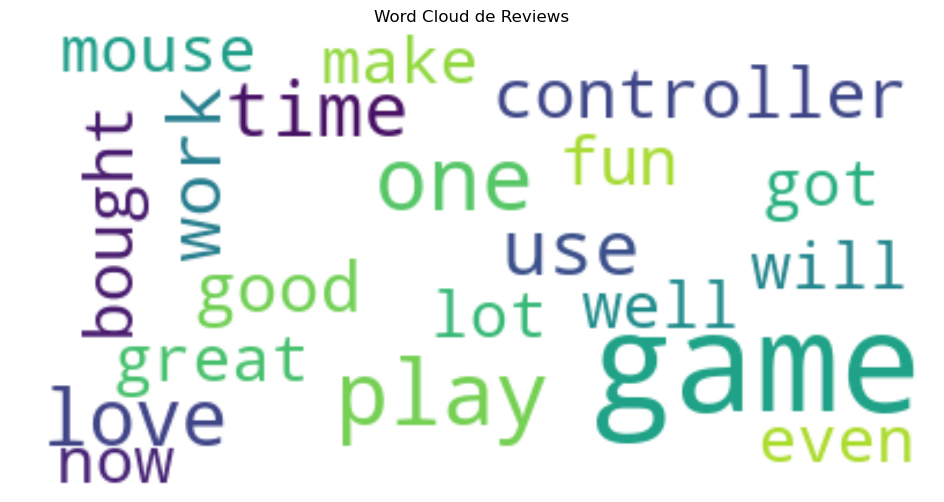

In [118]:
# Concatenar todos los textos en una sola cadena
text = " ".join(df_partition['reviewText'])

# Crear un objeto WordCloud
wordcloud = WordCloud(max_font_size=60, max_words=20, background_color='white', colormap='viridis').generate(text)

# Mostrar la gráfica
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud de Reviews')
plt.show()

Nube de palabras generada a partir de todas las muestras de reseñas negativas, es decir, aquellas con una calificación igual o inferior a 3 estrellas.

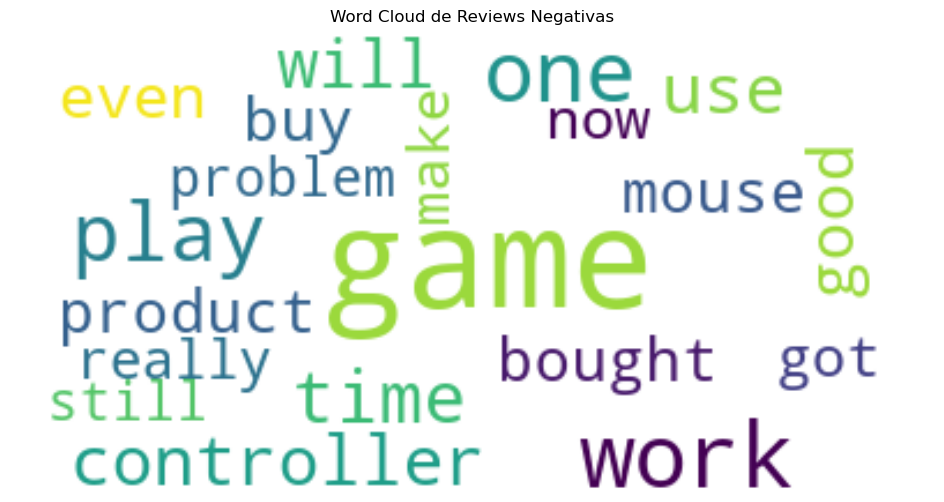

In [119]:
# Filtrar solo los textos de las reviews con sentimiento negativo
negative_reviews = df_partition[df_partition['sentiment'] == 'Negativo']['reviewText']

# Concatenar todos los textos en una sola cadena
text = " ".join(negative_reviews)

# Crear un objeto WordCloud
wordcloud = WordCloud(max_font_size=60, max_words=20, background_color='white', colormap='viridis').generate(text)

# Mostrar la gráfica
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud de Reviews Negativas')
plt.show()


Nube de palabras generada a partir de todas las muestras de reseñas positivas, es decir, aquellas con una calificación superior a 3 estrellas.

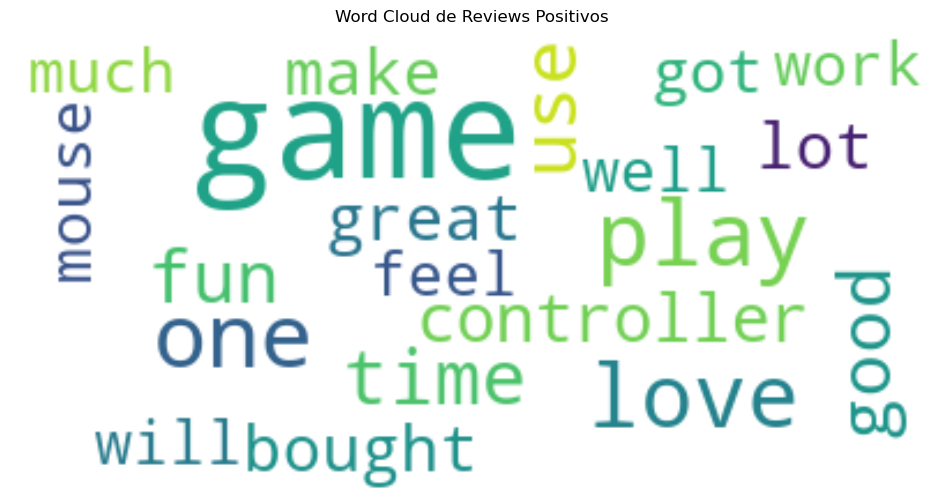

In [120]:
# Filtrar solo los textos de las reviews con sentimiento negativo
negative_reviews = df_partition[df_partition['sentiment'] == 'Positivo']['reviewText']

# Concatenar todos los textos en una sola cadena
text = " ".join(negative_reviews)

# Crear un objeto WordCloud
wordcloud = WordCloud(max_font_size=60, max_words=20, background_color='white', colormap='viridis').generate(text)

# Mostrar la gráfica
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud de Reviews Positivos')
plt.show()

## Pipeline

Creamos una función (nltk_cleaner) que limpia el texto de entrada, eliminando acentos, signos de puntuación, palabras vacías (stop words), y convirtiendo dígitos a palabras. Utiliza herramientas de procesamiento de lenguaje natural (NLTK) como tokenizadores, lista de palabras vacías y lematizadores para realizar estas tareas.

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
sw_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def nltk_cleaner(text, tokenizer = tokenizer, sw_list = sw_list, lemmatizer = lemmatizer):
    clean_text = list()

    # Eliminar acentos, etc
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Separar palabras eliminando signos de puntuación
    for word in tokenizer.tokenize(text):

        # Eliminar stop words
        if word not in sw_list:

        # Eliminar espacios sobrantes, convertir a minúsculas y lematizar
            clean_word = lemmatizer.lemmatize(word).lower().strip()

        # Convertir dígitos a palabras
            if clean_word.isdigit():
                clean_word = num2words(clean_word, lang='en')

            clean_text.append(clean_word)

    return ' '.join(clean_text)

In [122]:
 df_partition.head()

,overall,reviewText,sentiment
2416256,4.0,It's doing it's job and giving the tablet a lo...,Positivo
2077148,5.0,Very sturdy and great for the price! I purchas...,Positivo
1915753,5.0,Works great!,Positivo
2111817,5.0,Another awesome Amiibo!,Positivo
1769062,5.0,"Exactly as advertised, and just the right price!",Positivo


Procedemos a realizar una copia del dataframe llamada df_partition_nltk y creamos una nueva columna llamada "nltk" para almacenar los datos parcialmente limpios.

In [123]:
# Copiar df_partition para no modificar el original
df_partition_nltk = df_partition.copy()
# Crear la nueva columna 'preprocesado'
df_partition_nltk['nltk'] = df_partition_nltk['reviewText'].apply(nltk_cleaner)

Validamos la correcta creación de la columna con la información tratada.

In [124]:
 df_partition_nltk.head()

,overall,reviewText,sentiment,nltk
2416256,4.0,It's doing it's job and giving the tablet a lo...,Positivo,it job giving tablet longer use time
2077148,5.0,Very sturdy and great for the price! I purchas...,Positivo,very sturdy great price i purchased ten year o...
1915753,5.0,Works great!,Positivo,works great
2111817,5.0,Another awesome Amiibo!,Positivo,another awesome amiibo
1769062,5.0,"Exactly as advertised, and just the right price!",Positivo,exactly advertised right price


## Visualización en dos dimensiones de algunos word embeddings calculados con Word2Vec

Definimos los parámetros del modelo Word2Vec, inicializa el modelo Word2Vec con los parámetros especificados, construye el vocabulario utilizando los datos de texto preprocesados y muestra la cantidad de palabras en el vocabulario resultante.

In [125]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import numpy as np

In [126]:
corpus = df_partition_nltk['nltk'] .str.split()

In [127]:
# Definir parámetros
parametros = {
    'vector_size': 200,
    'window': 5,
    'min_count': 1,
    'sg': 1,
    'workers': 4
}
# Inicializar modelo Word2Vec
Word2Vec_sg = Word2Vec(**parametros)

# Construir el vocabulario
Word2Vec_sg.build_vocab(corpus)

# Imprimir la cantidad de palabras en el vocabulario
print('El vocabulario está compuesto por {} palabras'.format(len(Word2Vec_sg.wv.key_to_index)))

El vocabulario está compuesto por 63896 palabras


Por ultimo entrenamos el modelo Word2Vec utilizando el corpus cargado en memoria durante 10 épocas.

In [128]:
# Entrenar el modelo Word2Vec con el corpus cargado en memoria
Word2Vec_sg.train(corpus_iterable=corpus, total_examples=Word2Vec_sg.corpus_count, epochs=10)

(46082993, 52721730)

Luego, guardamos el modelo Word2Vec entrenado en un archivo llamado "w2v_sg_model.pkl" y ofrecemos un método para cargar el modelo previamente guardado desde ese archivo.

In [129]:
#Por si queremos guardar el modelo
Word2Vec_sg.save('./w2v_sg_model.pkl')

In [130]:
# Para cargar un modelo guardado
Word2Vec_sg = Word2Vec.load('./w2v_sg_model.pkl')

Realizamos una validación del modelo utilizando la función `print_sim_words`, la cual imprime las palabras más similares a una palabra dada según el modelo Word2Vec especificado. Luego, probamos esta función con una lista de palabras predefinidas, mostrando las palabras más similares a cada una de ellas según el modelo.

In [131]:
def print_sim_words(word, model):
    query = "Most similar to {}".format(word) 
    print(query)
    print("-"*len(query))
    
    for sim_word, sim_score in model.wv.most_similar(word):
        print("{}:{}{:.3f}".format(sim_word, " "*(20-len(sim_word)), sim_score))
    
    print("\n")

words_to_test = ['game', 'story','good', 'well', 'play']
for word in words_to_test:
    print_sim_words(word, Word2Vec_sg)


Most similar to game
--------------------
bomberman:           0.681
mutli:               0.676
similarites:         0.672
singalong:           0.672
itching:             0.664
rct3:                0.661
obsessively:         0.660
pervious:            0.659
occaision:           0.659
kirito:              0.657


Most similar to story
---------------------
storyline:           0.839
plot:                0.787
storytelling:        0.675
likeable:            0.661
suspenseful:         0.645
coherent:            0.645
plotline:            0.645
captivating:         0.642
intriguing:          0.642
characterization:    0.635


Most similar to good
--------------------
great:               0.800
decent:              0.781
suprisingly:         0.709
excellent:           0.700
nice:                0.678
tis:                 0.673
qualiy:              0.671
awesome:             0.655
bad:                 0.655
overears:            0.655


Most similar to well
--------------------
nicely:       

Genera una visualización de los clusters de palabras en un espacio bidimensional.

In [132]:
# Definir las palabras clave para visualización
keys = ['game', 'story','good', 'well', 'play']

# Preparar las listas de embeddings y palabras
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in Word2Vec_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(Word2Vec_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
print(word_clusters) 

[['bomberman', 'mutli', 'similarites', 'singalong', 'itching', 'rct3', 'obsessively', 'pervious', 'occaision', 'kirito'], ['storyline', 'plot', 'storytelling', 'likeable', 'suspenseful', 'coherent', 'plotline', 'captivating', 'intriguing', 'characterization'], ['great', 'decent', 'suprisingly', 'excellent', 'nice', 'tis', 'qualiy', 'awesome', 'bad', 'overears'], ['nicely', 'excellently', 'beautifully', 'fantastically', 'decently', 'wonderfully', 'perfectly', 'superbly', 'sturdily', 'great'], ['playing', 'stupefyingly', 'veg', 'permanantely', 'singalong', 'wifif', 'played', 'game', 'bombshell', 'ssbb']]


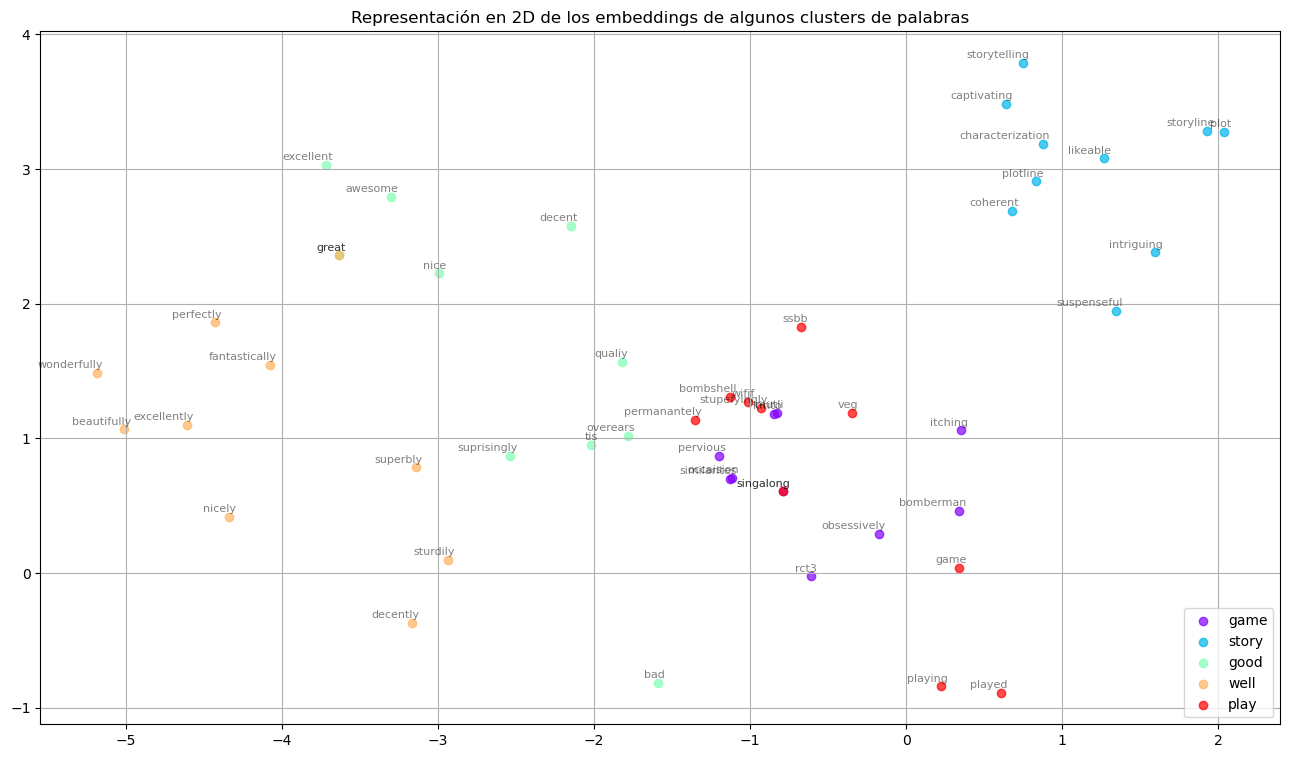

In [133]:
# Función para visualizar los clusters de palabras en 2D
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    plt.show()



# Configurar y ajustar el modelo t-SNE
model_2D = TSNE(perplexity=20, n_components=2, init='pca', n_iter=3500, random_state=69)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(model_2D.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

# Visualizar los clusters de palabras
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

las palabras similares proporcionadas sugieren asociaciones positivas y características deseables en los juegos, como la diversión, la facilidad de uso, la calidad general y las experiencias satisfactorias al jugar.

## Conclusiones EDA

La distribución de las reviews según el ranking de Amazon revela algunos puntos importantes:

La mayoría de las reviews cuentan con un ranking alto de 5 estrellas, representando alrededor del 60.61% del total de reviews analizadas. Esto indica una alta satisfacción por parte de los usuarios con los productos revisados en Amazon. Por otro lado, las reviews con un ranking más bajo (1 a 3 estrellas) constituyen un porcentaje significativamente menor del total, sugiriendo una proporción baja de críticas negativas en comparación con las positivas.

Estos hallazgos tienen implicaciones fundamentales para el análisis de sentimientos:

1. La predominancia de reviews con calificaciones de 4 y 5 estrellas sugiere una amplia satisfacción de los usuarios con los productos. Este factor puede sesgar el análisis de sentimientos hacia una inclinación positiva en las opiniones generales sobre los productos en cuestión.

2. La escasez de reviews con calificaciones de 1 a 3 estrellas indica que las críticas negativas son menos comunes. Esto puede dificultar la identificación y clasificación precisa de opiniones negativas por parte de los modelos de análisis de sentimientos, especialmente si hay una cantidad limitada de datos negativos disponible para entrenar los modelos.

3. La disparidad en la distribución de las calificaciones de las reviews puede ocasionar un desequilibrio de clases en el conjunto de datos utilizado para el análisis de sentimientos. Este desequilibrio puede afectar la capacidad del modelo para generalizar y predecir con precisión las opiniones, ya que puede estar sesgado hacia la clase dominante, es decir, las reviews e lenguaje..

A pesar del desbalance en la distribución de las valoraciones, he decidido mantener la distribución natural de las opiniones en el conjunto de datos. Esto se hace con el fin de obtener una comprensión más precisa de cómo los usuarios perciben realmente los artículos de la categoría de juegos.

# 2. Etapa de procesado de texto 

## Librerías, Configuración Librerias Requeridos Procesado de Texto

In [153]:
import nltk

# Descargar recursos necesarios de NLTK
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize, word_tokenize, TreebankWordTokenizer, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import unicodedata
from num2words import num2words
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pardo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pardo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pardo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Procesado de Texto

Procedemos a inicializar el lematizador de WordNet y reinicia los índices del DataFrame antes de continuar con el procesamiento de los datos.

In [160]:
# Inicializar el lematizador de WordNet
lemmatizer = WordNetLemmatizer()
#Se ha decidido reiniciar los índices antes de continuar con el procesamiento de los datos.
df_partition.reset_index(drop=True, inplace=True) 

Validamos los datos previo al procesamiento.

In [161]:
# Revisión
review = df_partition['reviewText'][1]
review

'Very sturdy and great for the price! I purchased it for my 10 year old son and it has been very useful in keeping his device from getting lost and all scratched up!'

In [155]:
df_partition.head()

,overall,reviewText,sentiment
0,4.0,It's doing it's job and giving the tablet a lo...,Positivo
1,5.0,Very sturdy and great for the price! I purchas...,Positivo
2,5.0,Works great!,Positivo
3,5.0,Another awesome Amiibo!,Positivo
4,5.0,"Exactly as advertised, and just the right price!",Positivo


Hemos desarrollado las funciones siguientes: `nltk_cleaner`, encargada de limpiar el texto de entrada eliminando acentos, caracteres especiales, signos de puntuación, stopwords y lematizando las palabras; y `data_cleaner`, que aplica `nltk_cleaner` a una lista de textos y devuelve una lista de textos limpios.

In [156]:
# Inicializar tokenizador, lista de palabras vacías y lematizador
tokenizer = RegexpTokenizer(r'\w+')
sw_list = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def nltk_cleaner(text, tokenizer, sw_list, lemmatizer):
    clean_text = []
    
    # Manejo de excepciones para texto nulo
    if not text:
        return ''
    
    # Eliminar acentos y caracteres especiales
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Separar palabras eliminando signos de puntuación y limpiar cada palabra
    for word in tokenizer.tokenize(text):
        # Eliminar stop words y lematizar las palabras
        clean_word = lemmatizer.lemmatize(word.lower().strip())
        
        # Convertir dígitos a palabras
        if clean_word.isdigit():
            clean_word = num2words(clean_word, lang='en')
        
        # Agregar palabra si no es una palabra vacía
        if clean_word not in sw_list:
            clean_text.append(clean_word)
            
    return ' '.join(clean_text)

def data_cleaner(text_list, tokenizer, sw_list, lemmatizer):
    cleaned_texts = []
    for text in text_list:
        cleaned_text = nltk_cleaner(text, tokenizer, sw_list, lemmatizer)
        cleaned_texts.append(cleaned_text)
    return cleaned_texts


Procedemos a procesar los textos utilizando las funciones mencionadas anteriormente y los almacenamos en la variable `data_processed`.

In [163]:
data_processed = data_cleaner(df_partition['reviewText'], tokenizer, sw_list, lemmatizer)

Antes del procesamiento:

In [164]:
df_partition['reviewText'][1]

'Very sturdy and great for the price! I purchased it for my 10 year old son and it has been very useful in keeping his device from getting lost and all scratched up!'

Despues del proceamiento:

In [165]:
data_processed[1]

'sturdy great price purchased ten year old son ha useful keeping device getting lost scratched'

# 3. Entrenamiento y Evaluación de un Modelo de Análisis de Sentimientos


## Librerías, Configuración Librerias Requeridos en el Entrenamiento y Evaluacion del Modelo de Análisis de Sentimientos


In [140]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

Procedemos a divider los datos procesados y las etiquetas de sentimiento en conjuntos de entrenamiento y prueba, utilizando una proporción del 75% para entrenamiento y 25% para prueba. Se establece una semilla para la aleatorización y se indica que los datos deben ser mezclados antes de la división.

In [167]:
X_train, X_test, y_train, y_test = train_test_split(data_processed, df_partition['sentiment'], train_size=0.75, test_size=0.25, random_state=69, shuffle=True)

Accedemos a los primeros 10 elementos del conjunto de entrenamiento `X_train`.

In [142]:
X_train[:10]

['skin great item add balance board look stability sure would helpful like board',
 'anti virus program would allow install computer',
 'product work great mounting bracket wa little wa able make work fan worked great easy install',
 'brake far stiff work pc cause immediate bsod soon plugged usb port',
 'far good used day ha kept ps4 cool charge controller nicely ha slot several game extensive collection may enough want display entire collection three usb connection provided front connects ps4 attached usb cable two charger port controller three usb port front expands device connection option unit hold ps4 securely feel wobbly feel sturdy',
 'lost original game happy wa able replace one time mac computer wa resonably priced',
 'montezuma five felt somewhat lazy followup unlike part three used able flip board twice whenever wanted totem power ups feel like pumped make waste point see difference otherwise big improvement part four still doe beat part three series felt like game replay ho

Accedemos a los primeros 10 elementos del conjunto de entrenamiento `y_train`.

In [143]:
y_train[:10]

66969     Positivo
170400    Negativo
150888    Positivo
137684    Negativo
112000    Positivo
55321     Positivo
26616     Negativo
167953    Positivo
126212    Positivo
133621    Positivo
Name: sentiment, dtype: object

Inicializamos un vectorizador TF-IDF con parámetros específicos, incluyendo el rango de n-gramas de 1 a 3, eliminación de acentos, umbral de frecuencia máxima de documento de 0.95, umbral de frecuencia mínima de documento de 3, y un límite máximo de características de 3000. Luego, el vectorizador se ajusta al conjunto de entrenamiento X_train.

In [144]:
cv = TfidfVectorizer(ngram_range=(1, 3), strip_accents='ascii', max_df=0.95, min_df=3, max_features=3000)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=3000, min_df=3, ngram_range=(1, 3),
                strip_accents='ascii')

In [145]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

Ahora aplicaremos regresión logística para ajustar el modelo, utilizando diferentes valores de parámetro de regularización. Calcularemos y registraremos la precisión de cada modelo en los conjuntos de entrenamiento y prueba, y luego imprimiremos los resultados de precisión para cada valor de C.

In [168]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = []
test_acc = []

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=10000)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))
    
    print("Accuracy for C={}: Train - {:.3f}, Test - {:.3f}".format(c, train_acc[-1], test_acc[-1]))


Accuracy for C=0.01: Train - 0.796, Test - 0.800
Accuracy for C=0.05: Train - 0.861, Test - 0.861
Accuracy for C=0.25: Train - 0.883, Test - 0.880
Accuracy for C=0.5: Train - 0.887, Test - 0.883
Accuracy for C=1: Train - 0.889, Test - 0.885
Accuracy for C=10: Train - 0.892, Test - 0.884
Accuracy for C=100: Train - 0.892, Test - 0.884
Accuracy for C=1000: Train - 0.892, Test - 0.885
Accuracy for C=10000: Train - 0.892, Test - 0.884


Encontramos que la precisión alcanza su punto máximo alrededor de C=1, tanto en el conjunto de entrenamiento como en el de prueba. Después de este punto, la precisión se mantiene relativamente constante, lo que sugiere que aumentar la complejidad del modelo más allá de este punto no resulta en mejoras significativas en la precisión del modelo.

## Matriz de confusión

In [169]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))

Confussion matrix:
[[ 7727  3673]
 [ 1980 35288]]


In [170]:
conf_matrix = confusion_matrix(y_test, test_predict)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

print('Confusion matrix (in %):\n{}'.format(conf_matrix_percent))

Confusion matrix (in %):
[[67.78070175 32.21929825]
 [ 5.31286895 94.68713105]]


La matriz de confusión muestra que el modelo clasificó correctamente la mayoría de las muestras como positivas, con un 94.68% de precisión, pero tuvo un rendimiento inferior en la clasificación de muestras negativas, con solo un 67.78% de precisión. Esto indica que el modelo tiende a ser más preciso en la identificación de muestras positivas que en la identificación de muestras negativas.

## Informe de clasificación

In [171]:
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))


Classification report:
              precision    recall  f1-score   support

    Negativo       0.80      0.68      0.73     11400
    Positivo       0.91      0.95      0.93     37268

    accuracy                           0.88     48668
   macro avg       0.85      0.81      0.83     48668
weighted avg       0.88      0.88      0.88     48668



Para la clase negativa:
- Precisión: Indica que el 80% de las muestras clasificadas como negativas son realmente negativas.
- Recall (sensibilidad): Representa el 68% de las muestras negativas reales clasificadas correctamente como negativas por el modelo.
- Puntaje F1: Corresponde al 73%, una medida combinada de precisión y recall.

Para la clase positiva:
- Precisión: Se sitúa en el 91%, lo que significa que el 91% de las muestras clasificadas como positivas son genuinamente positivas.
- Recall: El 95% de las muestras positivas reales fueron identificadas como positivas por el modelo.
- Puntaje F1: Alcanza el 93%.

El informe de clasificación indica que el modelo es más preciso en la identificación de muestras positivas que en la de muestras negativas. En resumen, tiene una precisión general del 88% y demuestra un buen rendimiento en la clasificación de ambas clases, aunque ligeramente inferior en la clase negativa en comparación con la clase positiva.

## Puntaje de precisión del modelo

In [172]:
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Accuracy score:0.8838456480644366


El puntaje de precisión del modelo es del 88.38%, lo que implica que aproximadamente el 88.38% de las muestras en el conjunto de prueba fueron clasificadas correctamente. En mi opinión, esto sugiere que el modelo exhibe un buen desempeño en la clasificación de las muestras en el conjunto de prueba.

## Gráfico que muestra cómo evoluciona la precisión del modelo

El gráfico muestra cómo evoluciona la precisión del modelo en los conjuntos de entrenamiento y prueba en función de diferentes valores de C utilizados en la regresión logística. La línea punteada verde indica el valor de C que maximiza la precisión en el conjunto de prueba.

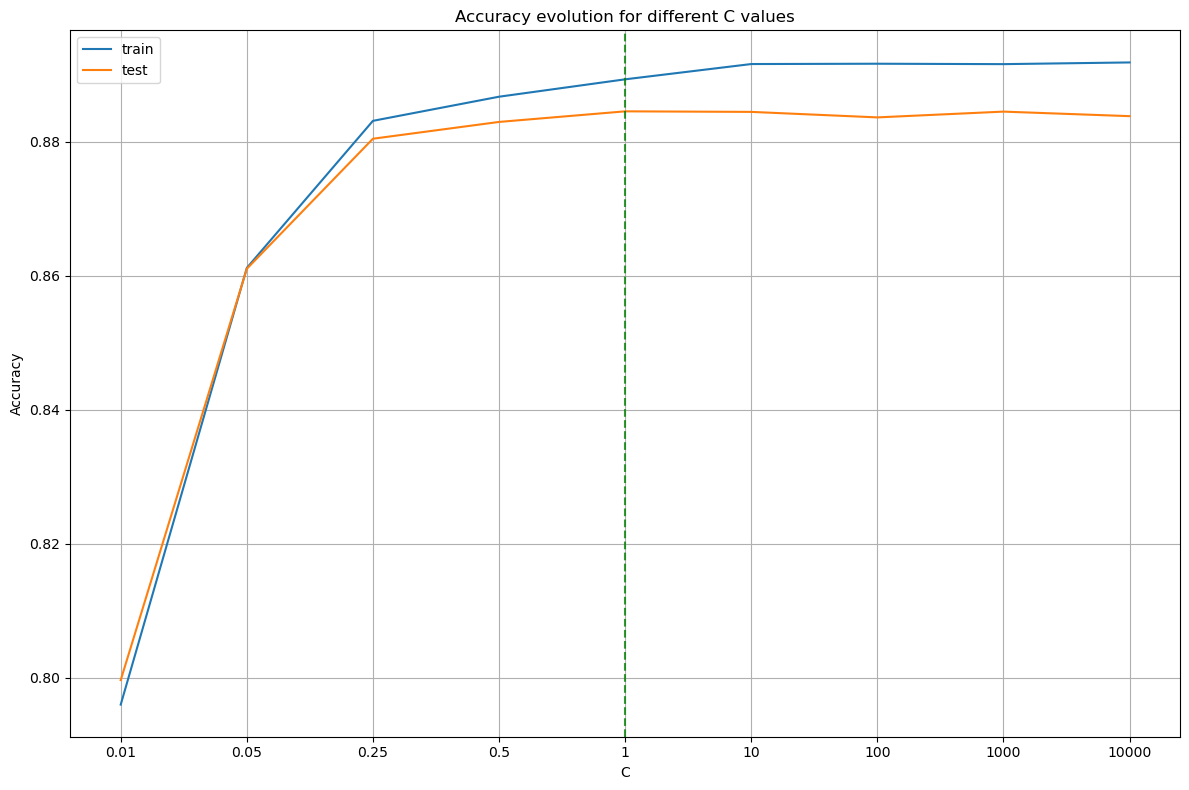

In [173]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

## Modelo de Clasificación Gradient Boosting

Vamos a entrenar un modelo de clasificación Gradient Boosting y evalúa su precisión en los conjuntos de entrenamiento y prueba.

In [174]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)

    clf.fit(X_train, y_train)
    
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    
    return clf


clf2 = classify_gboost(X_train_, X_test_, y_train, y_test)

[GradientBoostingClassifier] Accuracy: train = 0.8174626548769546, test = 0.8168611818854278


Como se puede ver precisión del modelo de clasificación Gradient Boosting es muy similar entre los conjuntos de entrenamiento y prueba, con valores cercanos al 82%. Esto sugiere que el modelo generaliza bien a datos no vistos y no muestra signos de sobreajuste. En general, el modelo parece tener un buen desempeño en la tarea de clasificación.

# Deep Learning

In [175]:
X_train_[0]

<1x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [176]:
X_train_aux=X_train_.toarray()
X_test_aux=X_test_.toarray()

In [178]:
from keras.preprocessing import sequence

max_words = 3000

X_train_lstm = sequence.pad_sequences(X_train_aux, maxlen=max_words)
X_test_lstm = sequence.pad_sequences(X_test_aux, maxlen=max_words)
     

El siguiente modelo de red neuronal recurrente (RNN) utilizando Keras, con capas de embedding y LSTM, y luego lo entrena utilizando datos de entrenamiento y validación, especificando el tamaño del lote y el número de épocas.

In [184]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Definir el tamaño del vocabulario y del embedding
vocabulary_size = 5000
embedding_size = 32

# Inicializar el modelo secuencial
model = Sequential()

# Añadir la capa de embedding
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

# Añadir la capa LSTM
model.add(LSTM(100))

# Añadir la capa densa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convertir las etiquetas de destino a valores numéricos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Dividir el conjunto de entrenamiento para obtener datos de validación
X_train2, X_valid, y_train2, y_valid = train_test_split(X_train_lstm, y_train_encoded, test_size=0.1, random_state=42)

# Entrenar el modelo
batch_size = 64
num_epochs = 1
model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)


2054/2054 [==============================] - 44576s 22s/step - loss: 0.5499 - accuracy: 0.7618 - val_loss: 0.5496 - val_accuracy: 0.7614


In [185]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3000, 32)          160000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               53200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 213301 (833.21 KB)
Trainable params: 213301 (833.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Calculo de la precisión del modelo de deep learning

In [191]:
# Codificar las etiquetas de destino de los datos de prueba si es necesario
y_test_encoded = label_encoder.transform(y_test)

# Calcular la precisión del modelo en los datos de prueba
scores = model.evaluate(X_test_lstm, y_test_encoded, verbose=1)
print("Test accuracy:", scores[1])  # scores[1] debería corresponder a la precisión si pasaste metrics=['accuracy']

1521/1521 [==============================] - 583s 383ms/step - loss: 0.5447 - accuracy: 0.7658
Test accuracy: 0.7657598257064819


En el modelo de aprendizaje profundo, se ejecutó solo una época debido al prolongado tiempo de ejecución, que fue de aproximadamente 12 horas y 22 minutos. Durante el entrenamiento, se registró una pérdida de 0.5499 y una precisión del 76.18%. Estos mismos valores se reflejaron de manera similar en los datos de validación, con una pérdida cercana a 0.5496 y una precisión del 76.14%.

Estos resultados sugieren que el modelo exhibe un rendimiento relativamente constante tanto en los datos de entrenamiento como en los de prueba. Sin embargo, se observa una disminución del 12% en la precisión en comparación con el modelo de regresión logística, que alcanzó el 88%. Además, se sugiere que el modelo puede generalizar eficazmente con datos no vistos. No obstante, se plantea la necesidad de una evaluación más exhaustiva para determinar si aumentar el número de épocas podría mejorar la precisión sin causar sobreajuste u otros efectos adversos.

# Conclusiones de la Práctica

Antes de proceder con el análisis de los datos, dediqué tiempo a investigar diferentes enfoques para abordar el problema. Dentro de estas investigaciones, encontré posturas que enfatizaban la importancia de trabajar con datos reales sin aplicar técnicas de balanceo, argumentando que esto podría comprometer la representatividad del modelo y su capacidad para generalizar frente a nuevos datos.

Por lo tanto, opté por realizar el análisis sin aplicar balanceo al conjunto de datos, con la intención de evaluar posteriormente cómo variarían las métricas actuales en comparación con los resultados obtenidos utilizando datos balanceados. Aunque se reconoce la posibilidad de un sesgo hacia la clase mayoritaria debido a la abundancia de reseñas positivas, los resultados preliminares muestran una diferencia del 11% en la precisión de la clasificación entre reseñas positivas y negativas, lo que podría considerarse aceptable al considerar otros aspectos de los datos.

Al analizar el rendimiento del modelo en la clasificación de reseñas positivas y negativas, se observa una disparidad en los resultados para cada clase. Mientras que el modelo presenta un rendimiento moderado en la identificación de reseñas negativas, con una precisión del 80%, un recall del 68%, y un puntaje F1 del 73%, exhibe un desempeño notablemente superior en la identificación de reseñas positivas, con una precisión del 91%, un recall del 95%, y un puntaje F1 del 93%.

Por otro lado, es importante destacar el desempeño del modelo de clasificación Gradient Boosting. Los resultados muestran una precisión muy similar entre los conjuntos de entrenamiento y prueba, con valores cercanos al 82%. Esto sugiere que el modelo generaliza bien a datos no vistos y no muestra signos de sobreajuste. En general, el modelo parece tener un buen desempeño en la tarea de clasificación.

Sin embargo, es importante resaltar la importancia de repetir el proceso de análisis con un dataframe ajustado para evaluar en qué medida varía la capacidad del modelo para procesar información nueva en tareas de Procesamiento del Lenguaje Natural (NLP).n.


tivas.